In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [ ]:
import os
import sqlite3
import json
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import torch
from tqdm import tqdm

# Set device for CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Sentence Transformer model
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')
model = model.to(device)

# Function to load data from JSON files
import json

# Load data for infringement & non-infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    # Extract input and reference text for non-infringement
    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    # Extract input and reference text for infringement
    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return (non_infringement_outputs, non_infringement_references, y_non_infringement,
            infringement_outputs, infringement_references, y_infringement)

# Example usage
non_infringement_outputs, non_infringement_references, y_non_infringement, \
infringement_outputs, infringement_references, y_infringement = load_data('non_infringement.json', 'infringement.json')

# Encode references in batches
def batch_encode_references(model, references, batch_size=8):
    all_vectors = []
    for i in tqdm(range(0, len(references), batch_size), desc="Encoding references"):
        batch = references[i:i + batch_size]
        batch_vectors = model.encode(batch, convert_to_tensor=True, device=device)
        all_vectors.append(batch_vectors.cpu().numpy())
    return np.vstack(all_vectors)

# Encode the complete references
reference_vectors = batch_encode_references(model, references)

# Initialize FAISS index
dimension = reference_vectors.shape[1]
nlist = 3
quantizer = faiss.IndexFlatL2(dimension)
gpu_index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)

# Train and add vectors to the FAISS index
print("Training the index...")
gpu_index.train(reference_vectors)
print("Index training completed.")
print("Adding vectors to the index...")
gpu_index.add(reference_vectors)
print("Vectors added to the index.")

# Setting up SQLite database to store text and embeddings
def setup_database():
    conn = sqlite3.connect('reference_db.sqlite')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS reference_data (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            text TEXT NOT NULL,
            embedding BLOB NOT NULL
        )
    ''')
    conn.commit()
    return conn

# Function to store references and their embeddings directly in the database
def store_references(conn, references, embeddings):
    cursor = conn.cursor()
    for ref, emb in zip(references, embeddings):
        # Store each embedding as binary
        cursor.execute('INSERT INTO reference_data (text, embedding) VALUES (?, ?)', 
                       (ref, emb.tobytes()))
    conn.commit()

# Store references in the database
conn = setup_database()
store_references(conn, references, reference_vectors)

# Function to find the most relevant reference based on input text
def search_next_sentence(input_text, top_k=1):
    print(f"Searching for next sentence for input: '{input_text}'...")
    input_vector = model.encode([input_text], convert_to_tensor=True, device=device).cpu().numpy()
    _, indices = gpu_index.search(input_vector, top_k)
    return [references[i] for i in indices[0]]

# Example input sentence
input_sentence = "foes right and left. Ser Rodrik hammered at the big man in the shadowskin cloak, their horses dancing round each other as they traded blow for blow."
next_sentence = search_next_sentence(input_sentence)
print("Recommended next sentence:", next_sentence)

# Close the database connection
conn.close()


In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 65/65 [00:19<00:00,  3.35it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 65/65 [00:01<00:00, 43.32it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 81/81 [00:23<00:00,  3.41it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 81/81 [00:00<00:00, 107.15it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   3%|▎         | 16/500 [00:00<00:11, 43.49it/s]

Epoch 10/500, Loss: 0.4859
Test Accuracy at Epoch 10: 87.18%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.98      0.78      0.87        65
non_infringement       0.78      0.98      0.87        52

        accuracy                           0.87       117
       macro avg       0.88      0.88      0.87       117
    weighted avg       0.89      0.87      0.87       117

New best model saved with accuracy 87.18% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.98      0.78      0.87        65
non_infringement       0.78      0.98      0.87        52

        accuracy                           0.87       117
       macro avg       0.88      0.88      0.87       117
    weighted avg       0.89      0.87      0.87       117



Training Epochs:   5%|▌         | 27/500 [00:00<00:09, 47.90it/s]

Epoch 20/500, Loss: 0.2138
Test Accuracy at Epoch 20: 86.32%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.87      0.89      0.88        65
non_infringement       0.86      0.83      0.84        52

        accuracy                           0.86       117
       macro avg       0.86      0.86      0.86       117
    weighted avg       0.86      0.86      0.86       117

Epoch 30/500, Loss: 0.1688
Test Accuracy at Epoch 30: 89.74%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        65
non_infringement       0.84      0.94      0.89        52

        accuracy                           0.90       117
       macro avg       0.90      0.90      0.90       117
    weighted avg       0.90      0.90      0.90       117

New best model saved with accuracy 89.74% at epoch 30
Best Classification Report at Epoch 30:
            

Training Epochs:   8%|▊         | 39/500 [00:02<00:39, 11.59it/s]

Epoch 40/500, Loss: 0.1238
Test Accuracy at Epoch 40: 88.89%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.90        65
non_infringement       0.84      0.92      0.88        52

        accuracy                           0.89       117
       macro avg       0.89      0.89      0.89       117
    weighted avg       0.89      0.89      0.89       117



Training Epochs:  11%|█         | 53/500 [00:03<00:33, 13.33it/s]

Epoch 50/500, Loss: 0.0889
Test Accuracy at Epoch 50: 88.03%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.92      0.86      0.89        65
non_infringement       0.84      0.90      0.87        52

        accuracy                           0.88       117
       macro avg       0.88      0.88      0.88       117
    weighted avg       0.88      0.88      0.88       117



Training Epochs:  13%|█▎        | 63/500 [00:03<00:24, 17.94it/s]

Epoch 60/500, Loss: 0.0634
Test Accuracy at Epoch 60: 88.03%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.92      0.86      0.89        65
non_infringement       0.84      0.90      0.87        52

        accuracy                           0.88       117
       macro avg       0.88      0.88      0.88       117
    weighted avg       0.88      0.88      0.88       117



Training Epochs:  14%|█▍        | 71/500 [00:04<00:33, 12.99it/s]

Epoch 70/500, Loss: 0.0454
Test Accuracy at Epoch 70: 88.03%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.92      0.86      0.89        65
non_infringement       0.84      0.90      0.87        52

        accuracy                           0.88       117
       macro avg       0.88      0.88      0.88       117
    weighted avg       0.88      0.88      0.88       117



Training Epochs:  16%|█▌        | 81/500 [00:05<00:31, 13.11it/s]

Epoch 80/500, Loss: 0.0325
Test Accuracy at Epoch 80: 87.18%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  19%|█▊        | 93/500 [00:05<00:24, 16.91it/s]

Epoch 90/500, Loss: 0.0243
Test Accuracy at Epoch 90: 87.18%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  21%|██        | 106/500 [00:06<00:14, 27.69it/s]

Epoch 100/500, Loss: 0.0197
Test Accuracy at Epoch 100: 87.18%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  23%|██▎       | 117/500 [00:06<00:09, 40.29it/s]

Epoch 110/500, Loss: 0.0171
Test Accuracy at Epoch 110: 87.18%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 120/500, Loss: 0.0155
Test Accuracy at Epoch 120: 88.03%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.92      0.86      0.89        65
non_infringement       0.84      0.90      0.87        52

        accuracy                           0.88       117
       macro avg       0.88      0.88      0.88       117
    weighted avg       0.88      0.88      0.88       117



Training Epochs:  27%|██▋       | 136/500 [00:06<00:07, 51.08it/s]

Epoch 130/500, Loss: 0.0146
Test Accuracy at Epoch 130: 88.03%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.92      0.86      0.89        65
non_infringement       0.84      0.90      0.87        52

        accuracy                           0.88       117
       macro avg       0.88      0.88      0.88       117
    weighted avg       0.88      0.88      0.88       117

Epoch 140/500, Loss: 0.0139
Test Accuracy at Epoch 140: 87.18%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  32%|███▏      | 160/500 [00:07<00:06, 50.82it/s]

Epoch 150/500, Loss: 0.0135
Test Accuracy at Epoch 150: 87.18%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 160/500, Loss: 0.0132
Test Accuracy at Epoch 160: 87.18%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  36%|███▌      | 180/500 [00:07<00:06, 52.59it/s]

Epoch 170/500, Loss: 0.0129
Test Accuracy at Epoch 170: 87.18%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 180/500, Loss: 0.0127
Test Accuracy at Epoch 180: 87.18%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  40%|████      | 200/500 [00:08<00:05, 51.93it/s]

Epoch 190/500, Loss: 0.0125
Test Accuracy at Epoch 190: 87.18%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 200/500, Loss: 0.0124
Test Accuracy at Epoch 200: 87.18%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  44%|████▍     | 220/500 [00:08<00:05, 53.99it/s]

Epoch 210/500, Loss: 0.0123
Test Accuracy at Epoch 210: 87.18%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 220/500, Loss: 0.0122
Test Accuracy at Epoch 220: 87.18%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  47%|████▋     | 235/500 [00:08<00:05, 51.72it/s]

Epoch 230/500, Loss: 0.0121
Test Accuracy at Epoch 230: 87.18%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  50%|████▉     | 249/500 [00:08<00:04, 56.95it/s]

Epoch 240/500, Loss: 0.0121
Test Accuracy at Epoch 240: 87.18%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 250/500, Loss: 0.0120
Test Accuracy at Epoch 250: 87.18%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  54%|█████▍    | 269/500 [00:09<00:03, 58.23it/s]

Epoch 260/500, Loss: 0.0120
Test Accuracy at Epoch 260: 87.18%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 270/500, Loss: 0.0119
Test Accuracy at Epoch 270: 87.18%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  58%|█████▊    | 290/500 [00:09<00:03, 58.40it/s]

Epoch 280/500, Loss: 0.0119
Test Accuracy at Epoch 280: 87.18%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 290/500, Loss: 0.0118
Test Accuracy at Epoch 290: 87.18%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  62%|██████▏   | 312/500 [00:10<00:03, 59.57it/s]

Epoch 300/500, Loss: 0.0118
Test Accuracy at Epoch 300: 87.18%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 310/500, Loss: 0.0118
Test Accuracy at Epoch 310: 87.18%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  65%|██████▌   | 327/500 [00:10<00:02, 58.87it/s]

Epoch 320/500, Loss: 0.0118
Test Accuracy at Epoch 320: 87.18%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 330/500, Loss: 0.0117
Test Accuracy at Epoch 330: 87.18%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  70%|███████   | 350/500 [00:10<00:02, 58.81it/s]

Epoch 340/500, Loss: 0.0117
Test Accuracy at Epoch 340: 87.18%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 350/500, Loss: 0.0117
Test Accuracy at Epoch 350: 87.18%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  73%|███████▎  | 365/500 [00:10<00:02, 63.92it/s]

Epoch 360/500, Loss: 0.0117
Test Accuracy at Epoch 360: 87.18%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 370/500, Loss: 0.0117
Test Accuracy at Epoch 370: 87.18%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  78%|███████▊  | 388/500 [00:11<00:01, 65.04it/s]

Epoch 380/500, Loss: 0.0117
Test Accuracy at Epoch 380: 87.18%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 390/500, Loss: 0.0116
Test Accuracy at Epoch 390: 87.18%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  82%|████████▏ | 410/500 [00:11<00:01, 62.92it/s]

Epoch 400/500, Loss: 0.0116
Test Accuracy at Epoch 400: 87.18%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117

Epoch 410/500, Loss: 0.0116
Test Accuracy at Epoch 410: 87.18%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  85%|████████▌ | 425/500 [00:11<00:01, 50.76it/s]

Epoch 420/500, Loss: 0.0116
Test Accuracy at Epoch 420: 87.18%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  86%|████████▌ | 431/500 [00:12<00:03, 21.65it/s]

Epoch 430/500, Loss: 0.0116
Test Accuracy at Epoch 430: 87.18%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  88%|████████▊ | 440/500 [00:13<00:03, 15.23it/s]

Epoch 440/500, Loss: 0.0116
Test Accuracy at Epoch 440: 87.18%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  90%|█████████ | 452/500 [00:14<00:03, 12.50it/s]

Epoch 450/500, Loss: 0.0116
Test Accuracy at Epoch 450: 87.18%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  92%|█████████▏| 462/500 [00:15<00:02, 12.74it/s]

Epoch 460/500, Loss: 0.0116
Test Accuracy at Epoch 460: 87.18%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  94%|█████████▍| 472/500 [00:16<00:02, 11.80it/s]

Epoch 470/500, Loss: 0.0116
Test Accuracy at Epoch 470: 87.18%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  96%|█████████▌| 481/500 [00:16<00:01, 17.32it/s]

Epoch 480/500, Loss: 0.0116
Test Accuracy at Epoch 480: 87.18%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs:  99%|█████████▉| 494/500 [00:17<00:00, 23.33it/s]

Epoch 490/500, Loss: 0.0115
Test Accuracy at Epoch 490: 87.18%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



Training Epochs: 100%|██████████| 500/500 [00:17<00:00, 28.73it/s]
/tmp/ipykernel_2595178/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0115
Test Accuracy at Epoch 500: 87.18%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.90      0.86      0.88        65
non_infringement       0.84      0.88      0.86        52

        accuracy                           0.87       117
       macro avg       0.87      0.87      0.87       117
    weighted avg       0.87      0.87      0.87       117



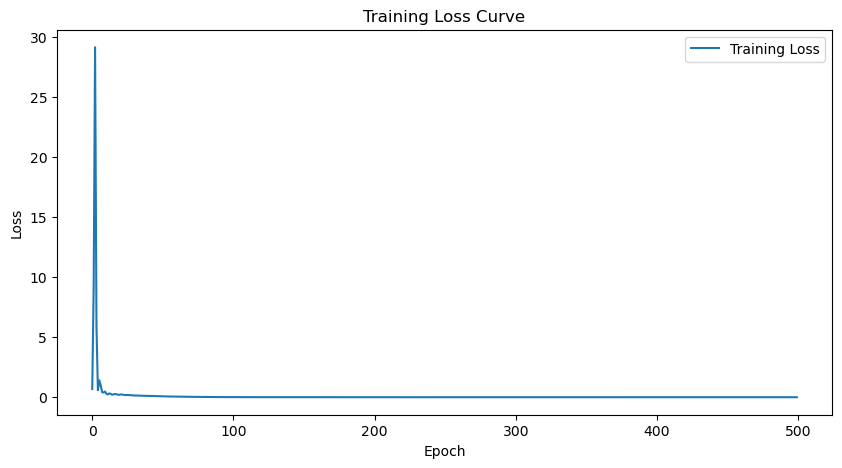

Final Model Accuracy: 89.74%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        65
non_infringement       0.84      0.94      0.89        52

        accuracy                           0.90       117
       macro avg       0.90      0.90      0.90       117
    weighted avg       0.90      0.90      0.90       117



/tmp/ipykernel_2595178/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 